In [1]:
from taseries import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read sugar future SR701 data and generate return series
df = pd.read_csv('../data/SR701.csv',index_col='date',parse_dates=['date'])
hold_day = 20
# note that SR701 data is reverse chronically ordered
df['rtn'] = np.log(df['close'].shift(hold_day + 1) / df['close'].shift(1))
rtn_series = df['rtn'].dropna()
rtn_series.name = 'rtn'
#print(rtn_series)
close_series = df['close'].shift(1).dropna()
close_series.name = 'close'
series_exp = SeriesExplorer(rtn_series)
#series_exp = SeriesExplorer(close_series)

# make potential independent variable series
ta_name_list = ['BBANDS_upper','BBANDS_middle','BBANDS_lower','MA','EMA','SMA','WMA','APO','MACD','MOM','PPO','RSI','WILLR','OBV','ATR']
ta = TAcalc()
ta.load_data('../data/CZZ.csv')

ta_se_list = []
for ta_name in ta_name_list:
    se = ta.generate_indicator(ta_name)
    ta_se_list.append(se)
    #print(se)

series_exp.add_indep_vars(ta_se_list)
series_exp.sync_index()
series_exp.fill_na()
#print(series_exp.indep[se.name])
#print(series_exp.data.head())

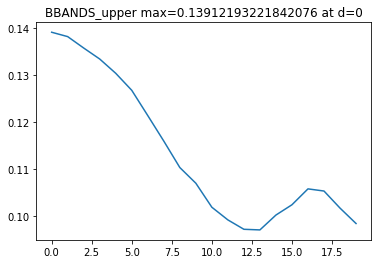

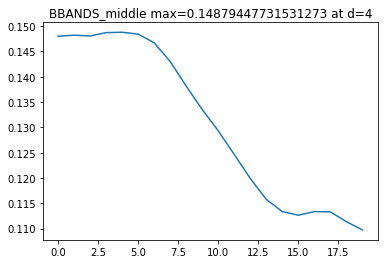

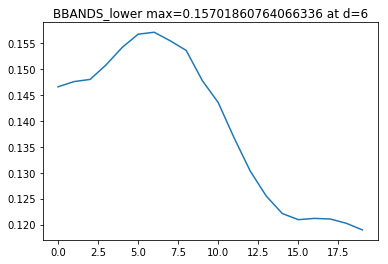

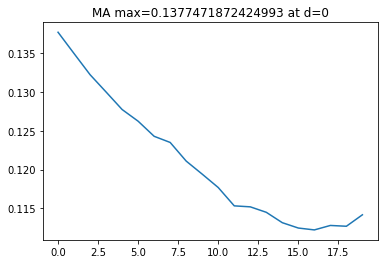

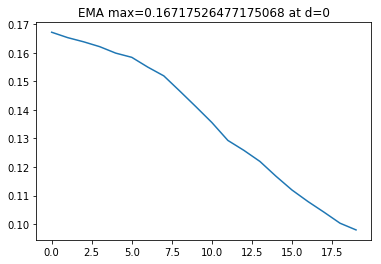

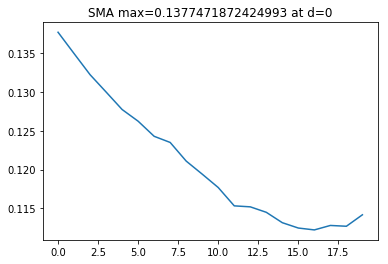

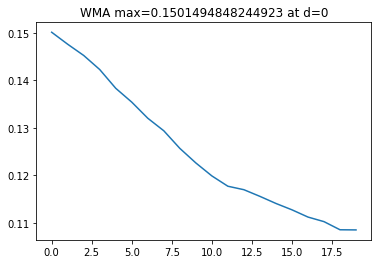

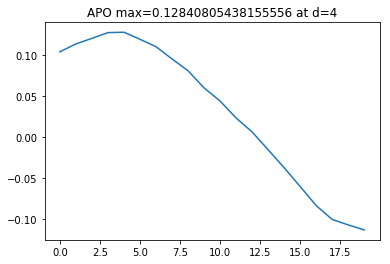

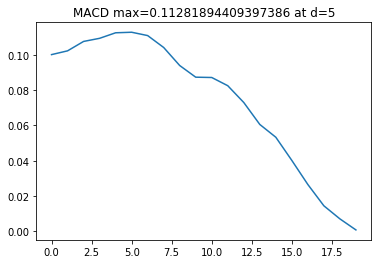

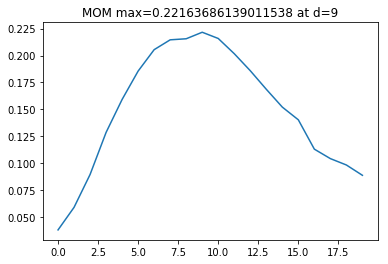

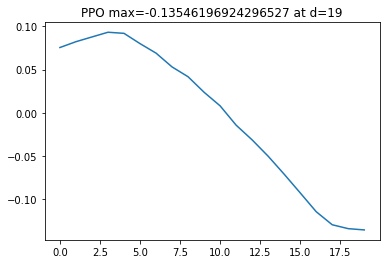

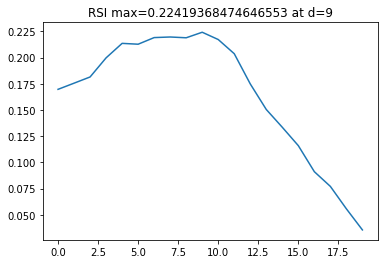

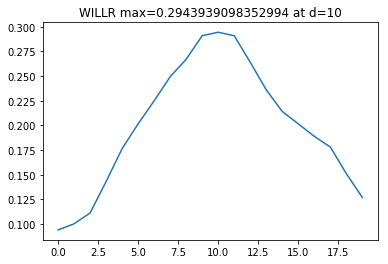

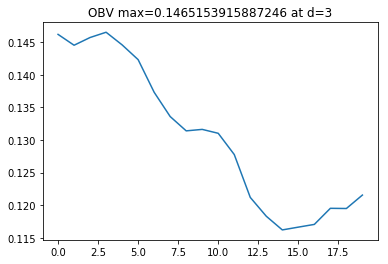

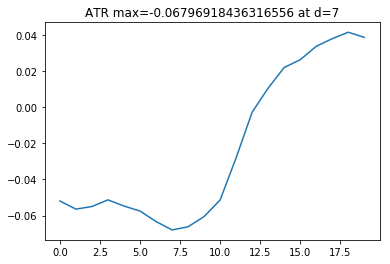

In [3]:
for ta_name in ta_name_list:
    series_exp.best_shift_test(key=ta_name,method='spearman',plot=True)